# Spotify Playlist Prediction
**Kevin Yoon, Madeleine Nakada, Michelle Xie**

*Something here about what we're doing*

## Import Libraries

In [2]:
import pandas as pd
import json
import random
from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter
import requests
import pprint
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import csv
# import sklearn.linear_model

In [3]:
pp = pprint.PrettyPrinter(indent=4)

In [4]:
#from spotify import get_features

In [5]:
import config
import base64

## Building the Data Set

We need to get additional information from Spotify since playlists only give us basic information like song title and artist. We make calls to 3 APIs for each song, which is slow so we've stored the information we need about songs we've already seen.

In [6]:
def get_token():
    cred = config.api_key
    byte =  cred.encode("utf-8")
    # b64Val = base64.b64encode(byte)
    b64 = base64.urlsafe_b64encode(cred.encode()).decode()
    auth = {'Authorization': 'Basic ' + b64}
    payload = {"grant_type": "client_credentials"}
    response = requests.post("https://accounts.spotify.com/api/token", 
        data=payload, headers=auth)
    return response.json()['access_token']
token = get_token()

base_url = "https://api.spotify.com/v1"
headers = {'Authorization': 'Bearer ' + token}


In [7]:
def get_features(songs):
    url = base_url + '/audio-features'
    i = 0
    features = []
    while i < len(songs):
        current = songs[i:i+100]
        payload = {'ids': ','.join(current)}
        r =requests.get(url, headers=headers, params=payload)
        data = r.json()
        features = features + data["audio_features"]
        i = i + 100
    return features

In [20]:
def get_genres(artists):
    genres = Counter()
    url = base_url + '/artists'
    i = 0
    genre_list = []
    while i < len(artists):
        current = artists[i:i+10]
        payload = {'ids': ','.join(current)}
        r =requests.get(url, headers=headers, params=payload)
        data = r.json()
        for artist in data['artists']:
            for genre in artist['genres']:
                genres[genre] += 1
            genre_list.append(artist['genres'])
        i = i + 10
    return genres, genre_list

In [9]:
def get_years(albums):
    years = Counter()
    years_list = []
    url = base_url + '/albums'
    i = 0
    while i < len(albums):
        current = albums[i:i+20]
        payload = {'ids': ','.join(current)}
        r =requests.get(url, headers=headers, params=payload)
        data = r.json()
        for album in data['albums']:
            date = album['release_date']
            year = date.split('-')[0]
            years[year] += 1
            years_list.append(year)
        i = i + 20
    return years, years_list

In [10]:
def get_popularity(songs):
    popularity = []
    url = base_url + '/tracks'
    i = 0
    while i < len(songs):
        current = songs[i:i+50]
        payload = {'ids': ','.join(current)}
        r =requests.get(url, headers=headers, params=payload)
        data = r.json()
        for track in data['tracks']:
            popularity.append(track['popularity'])
        i = i + 50
    return popularity

Create a progress bar function since getting the data can be slow and we want to make sure the program is still running. Also tracks number of failures for getting features which later we could troubleshoot but for now we're avoiding.

In [11]:
def progress_bar(index, total, failures):
    clear_output(wait=True)
    percent = index/total
    bars = "#" * int(percent * 30)
    lines = "-" * int((1-percent) * 30)
    display("|" + bars + lines + "| (%d/%d) with %d failures"%(index,total, failures))

Randomly select a set of 1000 playlists from the Million Playlist Dataset (this is easier than actually selecting 1000 playlists individually from such a massive data set) and extract the playlist information.

In [12]:
# add some code here to randomize selection

In [13]:
path = './mpd.slice.0-999.json'

with open(path) as infile:
    data = json.load(infile)
playlists = pd.DataFrame(data['playlists'])
playlists.set_index("pid")
playlists.shape

(1000, 12)

Add columns for our features which we get using the **get_features** function

In [14]:
feature_names = ["acousticness", "danceability","duration_ms",
            "energy","instrumentalness","key","liveness",
            "loudness","mode","speechiness","time_signature",
            "tempo","valence", "year", "popularity","genre"]
for feature in feature_names:
    playlists[feature] = None

In [15]:
playlists.head()

collaborative description duration_ms  modified_at              name  \
0         false         NaN        None   1493424000        Throwbacks   
1         false         NaN        None   1506556800  Awesome Playlist   
2         false         NaN        None   1505692800           korean    
3         false         NaN        None   1501027200               mat   
4         false         NaN        None   1401667200               90s   

   num_albums  num_artists  num_edits  num_followers  num_tracks  ...   \
0          47           37          6              1          52  ...    
1          23           21          5              1          39  ...    
2          51           31         18              1          64  ...    
3         107           86          4              1         126  ...    
4          16           16          7              2          17  ...    

   liveness loudness  mode speechiness time_signature tempo valence  year  \
0      None     None  None        None           None  None    None  None   
1      None     None  None        None           None  None    None  None   
2      None     None  None        None           None  None    None  None   
3      None     None  None        None           None  None    None  None   
4      None     None  None        None           None  None    None  None   

  popularity genre  
0       None  None  
1       None  None  
2       None  None  
3       None  None  
4       None  None  

[5 rows x 27 columns]

Get the features for each playlist (with our progress bar!)

In [16]:
with open('./songs/feature_data.txt', 'r') as infile:
    feature_data = eval(infile.read())
with open('./songs/genre_data.txt', 'r') as infile:
    genre_data = eval(infile.read())
with open('./songs/year_data.txt', 'r') as infile:
    year_data = eval(infile.read())
with open('./songs/popularity_data.txt', 'r') as infile:
    popularity_data = eval(infile.read())


In [17]:
len(feature_data)

27909

In [32]:
failures = 0
# iterate over all playlists
for index, row in playlists.iterrows():
    # render progress bar
    progress_bar(index + 1,playlists.shape[0], failures)
    # initialize all values to 0
    features = {
        "acousticness": 0,
        "danceability": 0,
        "duration_ms" : 0,
        "energy" : 0,
        "instrumentalness" : 0,
        "key" : 0,
        "liveness" : 0,
        "loudness" : 0,
        "mode" : 0,
        "speechiness" : 0,
        "time_signature" : 0,
        "tempo" : 0,
        "valence" : 0,
    }
    artists = set({})
    albums = set({})
    
#     artists = Counter()
#     counters = set(["artists"])
    all_features = set(features.keys())

    # get tracks for playlist
    tracks = row["tracks"]

    # seen stores the songs we've seen, songs stores new songs
    seen = []
    songs = []
    # iterate over all songs in playlist
    for track in tracks:
        track_id = track['track_uri'].split(":")[-1]
        
        # if we've seen the track, continue, otherwise get its identifiers
        if track_id in feature_data:
            seen.append(track_id)
        else:
            songs.append(track_id)
            artist_id = track['artist_uri'].split(":")[-1]
            artists.add(artist_id)
            album_id = track['album_uri'].split(":")[-1]
            albums.add(album_id)
    # get song data, either by looking up on API or in our files
    # if there's any issue with the failure we skip this row rather than
    # terminating the program
    try:
        # get information for new songs, returning counters and raw list
        song_features = get_features(songs)
        genres, genre_list = get_genres(list(artists))
        years, years_list = get_years(list(albums))
        popularity = get_popularity(songs)
        popularity_list = list(popularity)
        
        # add new songs to our database
        for song, feature, genre, year, pop in zip(songs, song_features, genre_list, years_list, popularity_list):
            feature_data[song] = feature
            genre_data[song] = genre
            year_data[song] = year
            popularity_data[song] = pop
        # add data from our seen songs
        for song in seen:
            song_features.append(feature_data[song])
            for genre in genre_data[song]:
                genres[genre] += 1
            popularity.append(popularity_data[song])
            years[year_data[song]] += 1
            
        # update popularity to be median value (not mean b/c outliers)
        popularity = np.median(popularity)
        features['popularity'] = popularity        

        # insert all information into features dict
        for song in song_features:
            for feature in all_features:

                features[feature] += song[feature]
        # average necessary values and update data table
        for feature in feature_names:
            if feature in all_features:
                features[feature] = features[feature] / len(tracks)
                if feature == "time_signature":
                    features[feature] = int(features[feature] + 0.5)
            elif feature == "year":
                features["year"] = int(years.most_common(1)[0][0])
            elif feature == "genre":
                features["genre"] = genres.most_common(1)[0][0]            
            playlists.at[index, feature] = features[feature]
    except Exception as ex:
        failures += 1



'|##############################| (1000/1000) with 23 failures'

[(81, KeyError('tracks',), 2), (90, KeyError('artists',), 2), (91, KeyError('tracks',), 2), (96, KeyError('albums',), 2), (219, KeyError('albums',), 2), (259, KeyError('tracks',), 2), (372, KeyError('artists',), 2), (497, TypeError("'NoneType' object is not subscriptable",), 2), (533, KeyError('tracks',), 2), (535, KeyError('artists',), 2), (549, KeyError('tracks',), 2), (553, KeyError('albums',), 2), (566, KeyError('albums',), 2), (583, KeyError('tracks',), 2), (597, KeyError('albums',), 2), (611, KeyError('artists',), 2), (618, KeyError('tracks',), 2), (782, TypeError("'NoneType' object is not subscriptable",), 2), (874, KeyError('tracks',), 2), (886, KeyError('artists',), 2), (927, KeyError('tracks',), 2), (946, KeyError('tracks',), 2), (961, KeyError('artists',), 2)]


In [21]:
# dicts= [feature_data, genre_data, year_data,popularity_data]

with open('./songs/feature_data.txt', 'w') as file:
    file.write(str(feature_data))
with open('./songs/genre_data.txt', 'w') as file:
    file.write(str(genre_data))
with open('./songs/year_data.txt', 'w') as file:
    file.write(str(year_data))
with open('./songs/popularity_data.txt', 'w') as file:
    file.write(str(popularity_data))

In [75]:

playlists.head()

collaborative description duration_ms  modified_at              name  \
0         false         NaN      221777   1493424000        Throwbacks   
1         false         NaN      298844   1506556800  Awesome Playlist   
2         false         NaN      219375   1505692800           korean    
3         false         NaN      229575   1501027200               mat   
4         false         NaN      255014   1401667200               90s   

   num_albums  num_artists  num_edits  num_followers  num_tracks  ...   \
0          47           37          6              1          52  ...    
1          23           21          5              1          39  ...    
2          51           31         18              1          64  ...    
3         107           86          4              1         126  ...    
4          16           16          7              2          17  ...    

   liveness loudness      mode speechiness time_signature    tempo   valence  \
0  0.192127 -4.88194  0.692308    0.107021              4  123.007  0.642904   
1  0.178433 -8.29167  0.538462   0.0884487              4   122.67  0.476667   
2  0.169028 -4.87416  0.515625   0.0962875              4  114.601  0.565078   
3  0.188585 -9.61494  0.714286   0.0671857              4  125.032  0.451623   
4  0.166524 -7.63447  0.823529   0.0411588              4   127.76  0.490765   

   year popularity genre  
0  2004         61     p  
1  1981         59     o  
2  2017         48     p  
3  2015         34     o  
4  1997         49     r  

[5 rows x 27 columns]

In [86]:
features = {
        "acousticness": 0,
        "danceability": 0,
        "duration_ms" : 0,
        "energy" : 0,
        "instrumentalness" : 0,
        "key" : 0,
        "liveness" : 0,
        "loudness" : 0,
        "mode" : 0,
        "speechiness" : 0,
        "time_signature" : 0,
        "tempo" : 0,
        "valence" : 0,
    }
for feature in list(features.keys()):
    playlists[feature] = pd.to_numeric(playlists[feature])

playlists[list(features.keys())].describe()

acousticness  danceability    duration_ms      energy  \
count    977.000000    977.000000     977.000000  977.000000   
mean       0.252326      0.603455  233356.808902    0.631595   
std        0.181026      0.093347   27255.007363    0.134180   
min        0.001561      0.224467  101610.818182    0.041362   
25%        0.129216      0.543461  218708.847826    0.570345   
50%        0.198144      0.605936  230744.775000    0.650034   
75%        0.318400      0.670670  245059.333333    0.726030   
max        0.989923      0.844500  411149.050000    0.934023   

       instrumentalness         key    liveness    loudness        mode  \
count        977.000000  977.000000  977.000000  977.000000  977.000000   
mean           0.055711    5.152325    0.188050   -7.439499    0.663832   
std            0.119096    0.687015    0.047200    2.495556    0.150791   
min            0.000000    0.571429    0.098562  -30.449077    0.100000   
25%            0.001701    4.800000    0.162346   -8.302636    0.555556   
50%            0.013200    5.150376    0.182988   -6.837786    0.655172   
75%            0.052590    5.521951    0.203867   -5.849056    0.777778   
max            0.914923    9.000000    0.717087   -3.591700    1.000000   

       speechiness  time_signature       tempo     valence  
count   977.000000      977.000000  977.000000  977.000000  
mean      0.093082        3.990788  121.097176    0.491268  
std       0.059412        0.095584    7.104991    0.123314  
min       0.030320        3.000000   83.653125    0.102700  
25%       0.051207        4.000000  116.743514    0.415666  
50%       0.074168        4.000000  121.363244    0.488858  
75%       0.115752        4.000000  125.154882    0.573407  
max       0.788188        4.000000  153.919429    0.898061

## Clean Up Data
Remove entries for which we couldn't get all song data

In [34]:
clean_data = playlists[playlists["time_signature"] > 0]
print(clean_data.shape)
clean_data.head()

(977, 27)


collaborative description duration_ms  modified_at              name  \
0         false         NaN      221777   1493424000        Throwbacks   
1         false         NaN      298844   1506556800  Awesome Playlist   
2         false         NaN      219375   1505692800           korean    
3         false         NaN      229575   1501027200               mat   
4         false         NaN      255014   1401667200               90s   

   num_albums  num_artists  num_edits  num_followers  num_tracks  ...   \
0          47           37          6              1          52  ...    
1          23           21          5              1          39  ...    
2          51           31         18              1          64  ...    
3         107           86          4              1         126  ...    
4          16           16          7              2          17  ...    

   liveness loudness      mode speechiness time_signature    tempo   valence  \
0  0.192127 -4.88194  0.692308    0.107021              4  123.007  0.642904   
1  0.178433 -8.29167  0.538462   0.0884487              4   122.67  0.476667   
2  0.169028 -4.87416  0.515625   0.0962875              4  114.601  0.565078   
3  0.188585 -9.61494  0.714286   0.0671857              4  125.032  0.451623   
4  0.166524 -7.63447  0.823529   0.0411588              4   127.76  0.490765   

   year popularity genre  
0  2004         61     p  
1  1981         59     o  
2  2017         48     p  
3  2015         34     o  
4  1997         49     r  

[5 rows x 27 columns]

Select playlists with at least 20 songs

In [42]:
big_data = clean_data[clean_data["num_tracks"] > 10]
print(big_data.shape)
big_data.head()

(927, 27)


collaborative description duration_ms  modified_at              name  \
0         false         NaN      221777   1493424000        Throwbacks   
1         false         NaN      298844   1506556800  Awesome Playlist   
2         false         NaN      219375   1505692800           korean    
3         false         NaN      229575   1501027200               mat   
4         false         NaN      255014   1401667200               90s   

   num_albums  num_artists  num_edits  num_followers  num_tracks  ...   \
0          47           37          6              1          52  ...    
1          23           21          5              1          39  ...    
2          51           31         18              1          64  ...    
3         107           86          4              1         126  ...    
4          16           16          7              2          17  ...    

   liveness loudness      mode speechiness time_signature    tempo   valence  \
0  0.192127 -4.88194  0.692308    0.107021              4  123.007  0.642904   
1  0.178433 -8.29167  0.538462   0.0884487              4   122.67  0.476667   
2  0.169028 -4.87416  0.515625   0.0962875              4  114.601  0.565078   
3  0.188585 -9.61494  0.714286   0.0671857              4  125.032  0.451623   
4  0.166524 -7.63447  0.823529   0.0411588              4   127.76  0.490765   

   year popularity genre  
0  2004         61     p  
1  1981         59     o  
2  2017         48     p  
3  2015         34     o  
4  1997         49     r  

[5 rows x 27 columns]

## Explore The Data

First we want to see if there are any features in which we don't see much variation, since these will likely not be helpful for prediction

In [35]:
big = 30

fig, ax=plt.subplots(13, 13, figsize=(130,130))
graphs = ax.ravel()
i = 0
for feature1 in feature_names[:13]:
    for feature2 in feature_names[:13]:
        graph = graphs[i]
        graph.scatter(clean_data[feature1], clean_data[feature2])
        graph.set_title(feature1 + " vs " + feature2, fontsize=big)
#     print(feature)
#     graph.hist(clean_data[feature], 25, histtype='stepfilled')
#     graph.set_title(feature)
#     graph.legend()
        i += 1

In [38]:
genre_counter = Counter()
for key in genre_data.keys():
#     print(genre_data[key])
    if type(genre_data[key]) == list:
        for genre in genre_data[key]:
            genre_counter[genre] += 1
    else:
        genre_counter[genre_data[key]] += 1


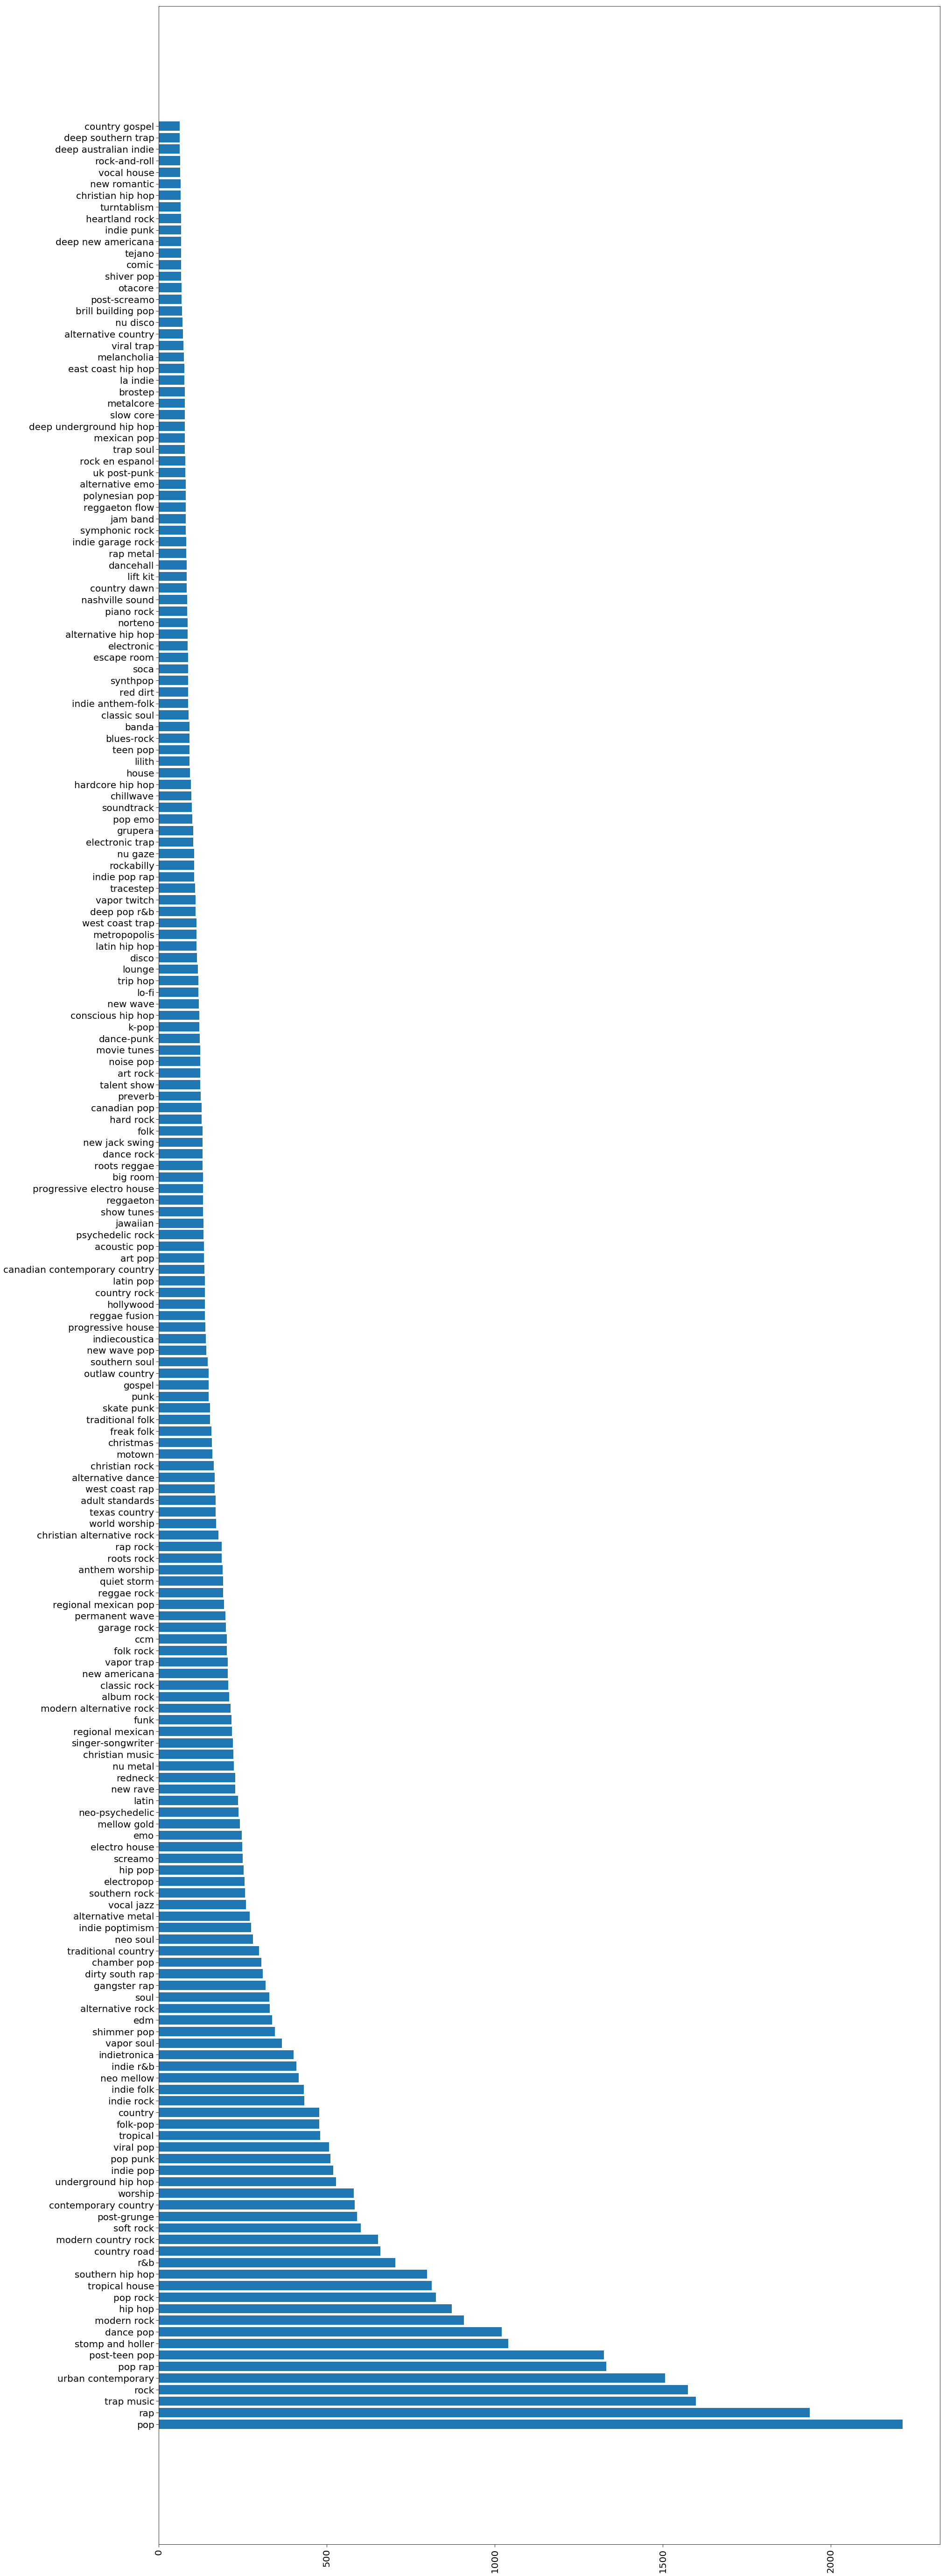

In [39]:
most = genre_counter.most_common(200)

genres = list(zip(*most))[0]
counts = list(zip(*most))[1]
x_pos = np.arange(len(genres)) 


# labels, values = zip(*genre_counter.items())
# indexes = np.arange(len(labels))
fig, ax=plt.subplots(1, 1, figsize=(30,100))
# # plt.
ax.barh(genres, counts)
plt.xticks(rotation=90)

ax.tick_params(labelsize=20, length=6)
# plt.xticks(indexes + width * 0.5, labels)
# ax.show()


Observations are in EDA write-up

## Split train and test data

In [43]:
train_data, test_data = train_test_split(big_data, test_size=0.2, random_state=42)

In [31]:
train_data.shape, test_data.shape

((571, 27), (143, 27))

In [32]:
train_data.head()

collaborative description duration_ms  modified_at      name  num_albums  \
377         false         NaN      222721   1366502400   Classic          12   
85          false         NaN      250348   1509235200       Gym          63   
291         false         NaN      228563   1494374400  country           59   
803         false         NaN      212852   1508630400   Country         128   
740         false         NaN      253017   1509062400      will         137   

     num_artists  num_edits  num_followers  num_tracks    ...      liveness  \
377           12          3              1          22    ...      0.206545   
85            45         33              2          72    ...      0.180235   
291           37          6              1          70    ...      0.164271   
803           67         62              1         204    ...      0.170857   
740           72         18              3         195    ...      0.187197   

    loudness      mode speechiness time_signature    tempo   valence  year  \
377   -18.07  0.681818   0.0476727              4   102.73    0.5198  2010   
85  -5.98874  0.597222   0.0973917              4  119.378  0.488858  2016   
291 -6.45546  0.942857   0.0403229              4  125.519  0.553529  2013   
803 -5.36179  0.892157   0.0417387              4  126.394  0.570672  2015   
740 -8.93922  0.784615   0.0633303              4  122.946  0.638203  1976   

    popularity      genre  
377         10  classical  
85          47        pop  
291         55    country  
803         41    country  
740         51       rock  

[5 rows x 27 columns]

In [45]:
def make_row(track_id):
    features = feature_data[track_id]
    for feature in features:
        if feature not in str_feature:
#                     print(feature)
            features[feature] = features[feature] - row[feature]
    popularity = popularity_data[track_id] - row['popularity']
    features["popularity"] = int(popularity)
    return features

In [46]:
columns=["acousticness", "danceability",
            "energy","instrumentalness","key","liveness",
            "loudness","mode","speechiness","time_signature",
            "tempo","valence", "popularity"]

str_feature = set(["analysis_url", "id", "uri", "type", "track_id", "track_href"])
song_keys = feature_data.keys()
train_data_songs = pd.DataFrame([], columns=columns)
train_data_y = []
train_songs = {}
i = 1
total = train_data.shape[0]
for index, row in train_data.iterrows():
    progress_bar(i, total, 0)
    i += 1

    tracks = set([])
    for index, track in enumerate(row["tracks"]):
        if index < 10:
            track_id = track["track_uri"].split(':')[-1]
            tracks.add(track_id)
            if track_id in feature_data:
                features = make_row(track_id)
                train_data_songs = train_data_songs.append(features, ignore_index=True)
                train_data_y.append(1)
    other_keys = random.sample(song_keys, 30)
    for key in other_keys:
        if not key in tracks and key in feature_data:
            features = make_row(key)
            train_data_songs = train_data_songs.append(features, ignore_index=True)
            train_data_y.append(0)
    
train_data_songs = train_data_songs.set_index("id")
# train_data_songs

# remove = ['tracks', "collaborative", "description", "modified_at", "name", "num_edits", "num_followers", "pid"]

# train_data_y = train_data["tracks"]
# train_data_x = train_data[train_data.columns.difference(remove)]
# for index, row in train_data.iterrows():
#     random.shuffle(row["tracks"])
#     train_data_y.append(row["tracks"][-5:])
# #     train_data_x.at[index,"tracks"] = row["tracks"][:-5]

'|##############################| (741/741) with 0 failures'

In [47]:
train_data_songs.head()

acousticness  danceability    energy  \
id                                                             
0WbhYfpQN3ay2XqKzggGOJ     -0.065388     -0.077245 -0.048491   
6lgzJuBX3iqevLdtgNlyAU     -0.118838      0.054755  0.006509   
6BaxqcoEM9r3LXisTyJjST      0.007812     -0.237245  0.090509   
67WTwafOMgegV6ABnBQxcE     -0.102388     -0.007245 -0.001491   
6lV2MSQmRIkycDScNtrBXO     -0.010188     -0.019245  0.127509   

                        instrumentalness       key  liveness  loudness  \
id                                                                       
0WbhYfpQN3ay2XqKzggGOJ         -0.006352  1.132075 -0.055796  0.114604   
6lgzJuBX3iqevLdtgNlyAU         -0.006352  5.132075 -0.021796  0.223604   
6BaxqcoEM9r3LXisTyJjST         -0.006352  3.132075 -0.070796  1.291604   
67WTwafOMgegV6ABnBQxcE         -0.006284 -5.867925 -0.107096 -1.733396   
6lV2MSQmRIkycDScNtrBXO         -0.006352  0.132075 -0.162996  1.026604   

                            mode  speechiness time_signature      tempo  \
id                                                                        
0WbhYfpQN3ay2XqKzggGOJ -0.622642    -0.027515              0   6.088604   
6lgzJuBX3iqevLdtgNlyAU  0.377358    -0.002315              0 -27.845396   
6BaxqcoEM9r3LXisTyJjST  0.377358     0.067485              0 -32.540396   
67WTwafOMgegV6ABnBQxcE  0.377358    -0.027915              0 -13.940396   
6lV2MSQmRIkycDScNtrBXO -0.622642     0.037485              0 -28.845396   

                         valence popularity  \
id                                            
0WbhYfpQN3ay2XqKzggGOJ -0.393094        -44   
6lgzJuBX3iqevLdtgNlyAU -0.060094         -8   
6BaxqcoEM9r3LXisTyJjST -0.021094          2   
67WTwafOMgegV6ABnBQxcE -0.207094         11   
6lV2MSQmRIkycDScNtrBXO -0.222094         15   

                                                             analysis_url  \
id                                                                          
0WbhYfpQN3ay2XqKzggGOJ  https://api.spotify.com/v1/audio-analysis/0Wbh...   
6lgzJuBX3iqevLdtgNlyAU  https://api.spotify.com/v1/audio-analysis/6lgz...   
6BaxqcoEM9r3LXisTyJjST  https://api.spotify.com/v1/audio-analysis/6Bax...   
67WTwafOMgegV6ABnBQxcE  https://api.spotify.com/v1/audio-analysis/67WT...   
6lV2MSQmRIkycDScNtrBXO  https://api.spotify.com/v1/audio-analysis/6lV2...   

                         duration_ms  \
id                                     
0WbhYfpQN3ay2XqKzggGOJ   2354.433962   
6lgzJuBX3iqevLdtgNlyAU -22325.566038   
6BaxqcoEM9r3LXisTyJjST  -4205.566038   
67WTwafOMgegV6ABnBQxcE  57087.433962   
6lV2MSQmRIkycDScNtrBXO -39472.566038   

                                                               track_href  \
id                                                                          
0WbhYfpQN3ay2XqKzggGOJ  https://api.spotify.com/v1/tracks/0WbhYfpQN3ay...   
6lgzJuBX3iqevLdtgNlyAU  https://api.spotify.com/v1/tracks/6lgzJuBX3iqe...   
6BaxqcoEM9r3LXisTyJjST  https://api.spotify.com/v1/tracks/6BaxqcoEM9r3...   
67WTwafOMgegV6ABnBQxcE  https://api.spotify.com/v1/tracks/67WTwafOMgeg...   
6lV2MSQmRIkycDScNtrBXO  https://api.spotify.com/v1/tracks/6lV2MSQmRIky...   

                                  type                                   uri  
id                                                                            
0WbhYfpQN3ay2XqKzggGOJ  audio_features  spotify:track:0WbhYfpQN3ay2XqKzggGOJ  
6lgzJuBX3iqevLdtgNlyAU  audio_features  spotify:track:6lgzJuBX3iqevLdtgNlyAU  
6BaxqcoEM9r3LXisTyJjST  audio_features  spotify:track:6BaxqcoEM9r3LXisTyJjST  
67WTwafOMgegV6ABnBQxcE  audio_features  spotify:track:67WTwafOMgegV6ABnBQxcE  
6lV2MSQmRIkycDScNtrBXO  audio_features  spotify:track:6lV2MSQmRIkycDScNtrBXO

In [48]:
# print(columns)
train_data_songs.dtypes
# train_data_songs[np.array(train_data_y) == 0][["popularity"]].describe()

acousticness        float64
danceability        float64
energy              float64
instrumentalness    float64
key                 float64
liveness            float64
loudness            float64
mode                float64
speechiness         float64
time_signature       object
tempo               float64
valence             float64
popularity           object
analysis_url         object
duration_ms         float64
track_href           object
type                 object
uri                  object
dtype: object

In [49]:
train_data_songs["popularity"] = train_data_songs["popularity"].astype("float64")

In [50]:
train_data_songs[np.array(train_data_y) == 1][columns].describe()

acousticness  danceability       energy  instrumentalness          key  \
count   7396.000000   7396.000000  7396.000000       7396.000000  7396.000000   
mean      -0.180676     -0.472906    -0.479118         -0.027373    -3.920535   
std        0.373370      0.798647     0.813440          0.170075     7.332741   
min       -2.990054    -10.218838    -9.353520         -1.372248   -73.298947   
25%       -0.329397     -0.690196    -0.728777         -0.070149    -7.053724   
50%       -0.129786     -0.149937    -0.186423         -0.018499    -3.122487   
75%        0.008122      0.023856     0.046894         -0.001795     1.047540   
max        0.800309      0.493808     0.553627          0.879644     7.833333   

          liveness     loudness         mode  speechiness        tempo  \
count  7396.000000  7396.000000  7396.000000  7396.000000  7396.000000   
mean     -0.138878     5.490026    -0.496545    -0.076748   -92.033691   
std       0.275037     9.254663     0.910176     0.169958   151.256952   
min      -2.894571   -20.302063    -8.857844    -2.194438 -1786.036225   
25%      -0.254977    -0.067471    -0.854745    -0.126043  -138.628160   
50%      -0.095064     2.567361    -0.430891    -0.041915   -32.330190   
75%      -0.017803     8.852670     0.226244    -0.005671     3.061072   
max       0.807347   102.501077     0.750000     0.612529    95.505800   

           valence   popularity  
count  7396.000000  7396.000000  
mean     -0.375358    -2.614927  
std       0.640509    20.141646  
min      -6.888341   -67.000000  
25%      -0.612768   -13.000000  
50%      -0.210599     0.000000  
75%       0.033480    11.000000  
max       0.721803    68.000000

In [51]:
train_data_songs[np.array(train_data_y) == 0][columns].describe()

acousticness  danceability        energy  instrumentalness  \
count  22226.000000  22226.000000  22226.000000      22226.000000   
mean      -0.116142     -0.305160     -0.302735         -0.010349   
std        0.403717      0.515976      0.565338          0.252881   
min       -2.762078     -6.635796     -6.560566         -1.703019   
25%       -0.335325     -0.564727     -0.585132         -0.076369   
50%       -0.126607     -0.151314     -0.166420         -0.017315   
75%        0.096327      0.047339      0.096920         -0.000676   
max        0.980738      0.633571      0.914638          0.973136   

                key      liveness      loudness          mode   speechiness  \
count  22226.000000  22226.000000  22226.000000  22226.000000  22226.000000   
mean      -2.439782     -0.086780      3.533139     -0.322718     -0.048822   
std        5.481821      0.226476      7.482083      0.717389      0.141412   
min      -52.179743     -1.708139    -34.308427     -5.754038     -1.300000   
25%       -5.228175     -0.204537     -0.863412     -0.746835     -0.118416   
50%       -2.246032     -0.082400      2.262171     -0.289564     -0.042718   
75%        1.711111      0.004579      7.180961      0.305085      0.002917   
max        8.187500      0.861438     70.266025      0.750000      0.900576   

              tempo       valence    popularity  
count  22226.000000  22226.000000  22226.000000  
mean     -58.420311     -0.240710    -11.229866  
std       99.498592      0.476984     24.517169  
min    -1217.469058     -4.712427    -77.000000  
25%     -114.984161     -0.476255    -28.000000  
50%      -24.326673     -0.175724    -10.000000  
75%        7.387144      0.087774      6.000000  
max      104.760978      0.797300     78.000000

In [52]:
train_data_x = train_data_songs[columns]
train_data_x.head()

acousticness  danceability    energy  \
id                                                             
0WbhYfpQN3ay2XqKzggGOJ     -0.065388     -0.077245 -0.048491   
6lgzJuBX3iqevLdtgNlyAU     -0.118838      0.054755  0.006509   
6BaxqcoEM9r3LXisTyJjST      0.007812     -0.237245  0.090509   
67WTwafOMgegV6ABnBQxcE     -0.102388     -0.007245 -0.001491   
6lV2MSQmRIkycDScNtrBXO     -0.010188     -0.019245  0.127509   

                        instrumentalness       key  liveness  loudness  \
id                                                                       
0WbhYfpQN3ay2XqKzggGOJ         -0.006352  1.132075 -0.055796  0.114604   
6lgzJuBX3iqevLdtgNlyAU         -0.006352  5.132075 -0.021796  0.223604   
6BaxqcoEM9r3LXisTyJjST         -0.006352  3.132075 -0.070796  1.291604   
67WTwafOMgegV6ABnBQxcE         -0.006284 -5.867925 -0.107096 -1.733396   
6lV2MSQmRIkycDScNtrBXO         -0.006352  0.132075 -0.162996  1.026604   

                            mode  speechiness time_signature      tempo  \
id                                                                        
0WbhYfpQN3ay2XqKzggGOJ -0.622642    -0.027515              0   6.088604   
6lgzJuBX3iqevLdtgNlyAU  0.377358    -0.002315              0 -27.845396   
6BaxqcoEM9r3LXisTyJjST  0.377358     0.067485              0 -32.540396   
67WTwafOMgegV6ABnBQxcE  0.377358    -0.027915              0 -13.940396   
6lV2MSQmRIkycDScNtrBXO -0.622642     0.037485              0 -28.845396   

                         valence  popularity  
id                                            
0WbhYfpQN3ay2XqKzggGOJ -0.393094       -44.0  
6lgzJuBX3iqevLdtgNlyAU -0.060094        -8.0  
6BaxqcoEM9r3LXisTyJjST -0.021094         2.0  
67WTwafOMgegV6ABnBQxcE -0.207094        11.0  
6lV2MSQmRIkycDScNtrBXO -0.222094        15.0

In [53]:
columns=["acousticness", "danceability",
            "energy","instrumentalness","key","liveness",
            "loudness","mode","speechiness","time_signature",
            "tempo","valence", "popularity"]

str_feature = set(["analysis_url", "id", "uri", "type", "track_id", "track_href"])
song_keys = feature_data.keys()
test_data_songs = pd.DataFrame([], columns=columns)
test_data_y = []
test_songs = {}
i = 1
total = test_data.shape[0]
for index, row in test_data.iterrows():
    progress_bar(i, total, 0)
    i += 1

    tracks = set([])
    for index, track in enumerate(row["tracks"]):
        if index < 10:
            track_id = track["track_uri"].split(':')[-1]
            tracks.add(track_id)
            if track_id in feature_data:
                features = make_row(track_id)
                test_data_songs = test_data_songs.append(features, ignore_index=True)
                test_data_y.append(1)
    other_keys = random.sample(song_keys, 30)
    for key in other_keys:
        if not key in tracks and key in feature_data:
            features = make_row(key)
            test_data_songs = test_data_songs.append(features, ignore_index=True)
            test_data_y.append(0)
    
test_data_songs = test_data_songs.set_index("id")
test_data_x = test_data_songs[columns]
train_data_x.head()

'|##############################| (186/186) with 0 failures'

acousticness  danceability    energy  \
id                                                             
0WbhYfpQN3ay2XqKzggGOJ     -0.065388     -0.077245 -0.048491   
6lgzJuBX3iqevLdtgNlyAU     -0.118838      0.054755  0.006509   
6BaxqcoEM9r3LXisTyJjST      0.007812     -0.237245  0.090509   
67WTwafOMgegV6ABnBQxcE     -0.102388     -0.007245 -0.001491   
6lV2MSQmRIkycDScNtrBXO     -0.010188     -0.019245  0.127509   

                        instrumentalness       key  liveness  loudness  \
id                                                                       
0WbhYfpQN3ay2XqKzggGOJ         -0.006352  1.132075 -0.055796  0.114604   
6lgzJuBX3iqevLdtgNlyAU         -0.006352  5.132075 -0.021796  0.223604   
6BaxqcoEM9r3LXisTyJjST         -0.006352  3.132075 -0.070796  1.291604   
67WTwafOMgegV6ABnBQxcE         -0.006284 -5.867925 -0.107096 -1.733396   
6lV2MSQmRIkycDScNtrBXO         -0.006352  0.132075 -0.162996  1.026604   

                            mode  speechiness time_signature      tempo  \
id                                                                        
0WbhYfpQN3ay2XqKzggGOJ -0.622642    -0.027515              0   6.088604   
6lgzJuBX3iqevLdtgNlyAU  0.377358    -0.002315              0 -27.845396   
6BaxqcoEM9r3LXisTyJjST  0.377358     0.067485              0 -32.540396   
67WTwafOMgegV6ABnBQxcE  0.377358    -0.027915              0 -13.940396   
6lV2MSQmRIkycDScNtrBXO -0.622642     0.037485              0 -28.845396   

                         valence  popularity  
id                                            
0WbhYfpQN3ay2XqKzggGOJ -0.393094       -44.0  
6lgzJuBX3iqevLdtgNlyAU -0.060094        -8.0  
6BaxqcoEM9r3LXisTyJjST -0.021094         2.0  
67WTwafOMgegV6ABnBQxcE -0.207094        11.0  
6lV2MSQmRIkycDScNtrBXO -0.222094        15.0

## Building the Model

Model ideas: Find similar songs to all the songs in the playlist using Last.fm. Then do some sort of classification to determine whether we want to add them to our playlist using some parameters and then continue. Alternatively, pick the best songs, then classify their similar. **Use a neural network**

*This might be making the problem too easy, so maybe we select 1000 songs from the Genre or something and classify them*

https://www.last.fm/api

TODO: Pick parameters to optimize prediction

- Get other songs by the same artist
- Get songs same genre time period

- Split a playlist in 3/4 (1/4 for response)
- "Train" it to predict the response songs

- Most common genre and time period
- Search spotify and get 200 songs
- Run that through Neural Network

In [54]:
from sklearn.linear_model import LogisticRegression

In [55]:
logreg = LogisticRegression(C=10000, solver='newton-cg', max_iter=250)
logreg.fit(train_data_x, train_data_y)

LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=250, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [63]:
coefs = zip(train_data_x.columns, logreg.coef_[0])
# print(list(coefs))
# print(logreg.coef_)
# print(train_data_x.columns)
# logreg.coef_

[('acousticness', 0.019084879457402042), ('danceability', -0.12317317487697946), ('energy', 0.018615373310492345), ('instrumentalness', 0.124873472876299), ('key', -0.004559730626635736), ('liveness', 0.09669683393820624), ('loudness', -0.003425070384646064), ('mode', -0.002926977501903132), ('speechiness', -0.01982533214189043), ('time_signature', -0.018188135200537973), ('tempo', -0.001071041455519947), ('valence', -0.050013891034148994), ('popularity', 0.015803524308805897)]


In [56]:
logreg.score(test_data_x, test_data_y)

0.7554208754208754

In [16]:
limit = 5
lastfmkey = "b4c63b3d7fb0c8d3ed670d8d78d737df"
def get_song_similar(song, artist):
    data = {'api_key': lastfmkey, 'artist': artist, 'track': song, 'limit': limit}
    response = requests.get('http://ws.audioscrobbler.com/2.0/?method=track.getsimilar&format=json', data=data)
    pp.pprint(response.content)